In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
#import torch.utils.tensorboard as tb
from Preprocessing.preprocessing_sorted import PreprocessingTrainingData
from torch.utils.data.sampler import SequentialSampler
import seaborn as sns
import matplotlib.pyplot as  plt
import os
import logging
torch.set_printoptions(profile="full")
import pandas as pd
import csv

In [28]:
#static parameters
train_batch_size = 78
val_batch_size = 78
sequence_length=50
test_batch_size = 1
input_size = 1
hidden_size = 256
num_layer = 2
output_size = 81
clip = 3

In [55]:
#get data from preprocessing.py
# dataset_path = os.path.join(os.path.abspath('..'),'CombinedData' )
# network_input,network_output,max_midi_number,min_midi_number,int_to_note = PreprocessingTrainingData().preprocess_notes(dataset_path)
# network_input, network_output = network_input.cuda(), network_output.cuda()

# # print(network_input)
# #print(network_output)

max_midi_number=105
min_midi_number=24
int_to_note={0: 24, 1: 26, 2: 27, 3: 28, 4: 29, 5: 30, 6: 31, 7: 32, 8: 33, 9: 34, 10: 35, 11: 36, 12: 37, 13: 38, 14: 39, 15: 40, 16: 41, 17: 42, 18: 43, 19: 44, 20: 45, 21: 46, 22: 47, 23: 48, 24: 49, 25: 50, 26: 51, 27: 52, 28: 53, 29: 54, 30: 55, 31: 56, 32: 57, 33: 58, 34: 59, 35: 60, 36: 61, 37: 62, 38: 63, 39: 64, 40: 65, 41: 66, 42: 67, 43: 68, 44: 69, 45: 70, 46: 71, 47: 72, 48: 73, 49: 74, 50: 75, 51: 76, 52: 77, 53: 78, 54: 79, 55: 80, 56: 81, 57: 82, 58: 83, 59: 84, 60: 85, 61: 86, 62: 87, 63: 88, 64: 89, 65: 90, 66: 91, 67: 92, 68: 93, 69: 94, 70: 95, 71: 96, 72: 97, 73: 98, 74: 99, 75: 100, 76: 101, 77: 102, 78: 103, 79: 104, 80: 105}

network_input=pd.read_csv('D:\\Prem\\Sem1\\MM in AI\\Project\\Project\\Sonification-using-Deep-Learning\\Sonification_using_LSTM\\Preprocessing\\network_input.csv') 
network_input=(network_input.values.reshape(network_input.shape[0],network_input.shape[1],1)).tolist()
for i in range(len(network_input)):
    for j in range(len(network_input[i])):
        network_input[i][j][0]=(network_input[i][j][0]-min_midi_number)/(max_midi_number-min_midi_number)
network_input=torch.Tensor(network_input).cuda()


network_output=pd.read_csv("D:\\Prem\\Sem1\\MM in AI\\Project\\Project\\Sonification-using-Deep-Learning\\Sonification_using_LSTM\\Preprocessing\\network_output.csv")
network_output=network_output.values.reshape(network_output.shape[0])
network_output=torch.Tensor(network_output).cuda()


In [56]:
print(network_output.max())
print(network_output.min())

tensor(80., device='cuda:0')
tensor(0., device='cuda:0')


In [57]:
# network_input[0]

In [58]:
network_output.shape

torch.Size([7806])

In [59]:
print(network_input.max())
print(network_input.min())
print(max_midi_number)
print(min_midi_number)
print(int_to_note)

tensor(1., device='cuda:0')
tensor(0.0247, device='cuda:0')
105
24
{0: 24, 1: 26, 2: 27, 3: 28, 4: 29, 5: 30, 6: 31, 7: 32, 8: 33, 9: 34, 10: 35, 11: 36, 12: 37, 13: 38, 14: 39, 15: 40, 16: 41, 17: 42, 18: 43, 19: 44, 20: 45, 21: 46, 22: 47, 23: 48, 24: 49, 25: 50, 26: 51, 27: 52, 28: 53, 29: 54, 30: 55, 31: 56, 32: 57, 33: 58, 34: 59, 35: 60, 36: 61, 37: 62, 38: 63, 39: 64, 40: 65, 41: 66, 42: 67, 43: 68, 44: 69, 45: 70, 46: 71, 47: 72, 48: 73, 49: 74, 50: 75, 51: 76, 52: 77, 53: 78, 54: 79, 55: 80, 56: 81, 57: 82, 58: 83, 59: 84, 60: 85, 61: 86, 62: 87, 63: 88, 64: 89, 65: 90, 66: 91, 67: 92, 68: 93, 69: 94, 70: 95, 71: 96, 72: 97, 73: 98, 74: 99, 75: 100, 76: 101, 77: 102, 78: 103, 79: 104, 80: 105}


In [60]:
network_input.shape

torch.Size([7806, 50, 1])

In [61]:
'''
data is highly unbalanced
# '''

# sns.distplot(torch.tensor(network_output).cpu())
# xx = pd.DataFrame(torch.tensor(network_output).cpu())
# xx.groupby(0).size().to_frame(name='values')

'\ndata is highly unbalanced\n# '

In [62]:
'''
to make batch of equal sizes
Quick Fix
'''
network_input = network_input[: -6]
network_output = network_output[: -6]

print(network_input.shape)
print(network_output.shape)

torch.Size([7800, 50, 1])
torch.Size([7800])


In [63]:
#network_input[0]

In [64]:
'''
create Stacked LSTM model
'''
class Stacked_LSTM(nn.Module):
    def __init__(self,input_size, hidden_size, num_layers, output_size):
        super().__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first = True, dropout = 0.5)
        
        self.dropout = nn.Dropout(0.5)
        self.linear = nn.Linear(hidden_size, output_size)
        
        
    def forward(self, x, hidden,batch_size):
        
        output, hidden = self.lstm(x, hidden)        
        #print(output.shape)
        
        # stack up lstm outputs
        output = output.contiguous().view(-1, self.hidden_size)
        #print(output.shape)
        
        output = self.dropout(output)
        output = self.linear(output)
        #print('Linear Output :-',output.shape)
        
        #output = F.softmax(output, dim = 1)
        #print('SOFTMAX OUTPUT :--', output)
        
        
        # reshape to be batch_size first
        output = output.view(batch_size, -1)
        #print('Reshape to batch size first :-',output.shape)
        
        output = output[:, -self.output_size:] # get last batch of labels
        #print('Final Output :-',output)
        #print('RESHAPE SIZE :-', output.shape)
        
        return output, hidden
    
    def hidden_init(self,batch_size):
        
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        hidden = (weight.new(self.num_layers, batch_size, self.hidden_size).zero_(),
          weight.new(self.num_layers, batch_size, self.hidden_size).zero_())
        return hidden

#initialize the weights of LSTM using Xavier initialization    
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)

    

In [65]:
'''
Divide the dataset into train/val 
'''
train_size = 0.8
indices = list(range(len(network_input)))
split = int(np.floor(train_size*len(network_input)))
train_idx, val_idx = indices[:split], indices[split:]

train_sampler = SequentialSampler(train_idx)
val_sampler = SequentialSampler(val_idx)

dataset = TensorDataset(network_input,network_output)
train_loader = DataLoader(dataset, batch_size= train_batch_size, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size= val_batch_size,sampler= val_sampler)

In [66]:
import torch.optim as optimizer

model = Stacked_LSTM(input_size,hidden_size,num_layer,output_size)
model.apply(init_weights)

criterion = nn.CrossEntropyLoss()
optimizer = optimizer.AdamW(model.parameters())
#optimizer = optimizer.RMSprop(model.parameters(), lr = 0.001, weight_decay = 0.01)


#make sure to transfer model to GPU after initializing optimizer
model.cuda()

Stacked_LSTM(
  (lstm): LSTM(1, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear): Linear(in_features=256, out_features=81, bias=True)
)

In [67]:
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.01
)

In [68]:
epochs = 500
min_val_loss = np.Inf

for e in range(epochs):
    
    train_loss = 0
    val_loss = 0
    train_accuracy = 0
    val_accuracy = 0
    
    
    hidden = model.hidden_init(train_batch_size)    
    #print('hidden[0].shape:- ',hidden[0].shape)
    
    for inputs,labels in train_loader:
        #print(inputs.shape)

        '''
        Creating new variables for the hidden state, otherwise
        we'd backprop through the entire training history
        '''
        h = tuple([each.data for each in hidden])
        

        # zero accumulated gradients
        model.zero_grad()
       
        # get the output from the model
        output, h = model.forward(inputs, h,train_batch_size)
        #print('OUTPUT', output)
        
        
        #print('Labels Shape :-', (torch.max(labels, 1)[1]).shape)
    
        # calculate the loss and perform backprop
        #print('Labels Long :-', labels.long())
        loss = criterion(output,labels.long())
        #print('LOSS IS :-', loss)
        
        loss.backward()
        
        #calculate training accuracy
        output = F.softmax(output, dim = 1)
        top_p, top_class = output.topk(1, dim=1)
        #logging.debug(' top probab {} top class {}'.format(top_p.view(-1, top_p.shape[0]), top_class.view(-1, top_p.shape[0])))

        equals = top_class == labels.long().view(*top_class.shape)
        train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        #nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        train_loss += loss.item()
        #print(train_loss)
              
    model.eval()
    for inputs, labels in val_loader:
                
        val_h = tuple([each.data for each in hidden])
        
        output, hidden = model.forward(inputs, val_h,val_batch_size)
       
        loss = criterion(output,labels.long())
        
        val_loss += loss.item()
        
        #calculate validation accuracy
        output = F.softmax(output, dim = 1)
        top_p, top_class = output.topk(1, dim=1)
        
        #logging.debug(output)
        #logging.debug('VALIDATION top probab {} VALIDATION top class {}'.format(top_p.view(-1, top_p.shape[0]), top_class.view(-1, top_p.shape[0])))

        #print('Top Class:- ',top_class)
        equals = top_class == labels.long().view(*top_class.shape)
        #print('Equals:- ', equals)
        val_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
    model.train()
    
    #Averaging losses
    train_loss = train_loss/len(train_loader)
    val_loss = val_loss/len(val_loader)
    val_accuracy = val_accuracy/len(val_loader)
    train_accuracy = train_accuracy/len(train_loader)
    
    print('Epoch: {}\tTrain Loss: {:.7f} \tVal Loss:{:.7f} \tTrain Acc: {:.7}% \tVal Acc: {:.7f}%'.format(e, train_loss, val_loss, train_accuracy*100,val_accuracy*100))
    
    #saving the model if validation loss is decreased
    if val_loss <= min_val_loss:
        print('Validation Loss decreased from {:6f} to {:6f}, saving the model weights'.format(min_val_loss, val_loss))
        torch.save(model.state_dict(), 'lstm_state_256_256_our_normalized_their_bakchodi_Combined_Data.pt')
        min_val_loss = val_loss

Epoch: 0	Train Loss: 4.2916786 	Val Loss:4.8100552 	Train Acc: 2.387821% 	Val Acc: 0.3205128%
Validation Loss decreased from    inf to 4.810055, saving the model weights
Epoch: 1	Train Loss: 4.2206886 	Val Loss:4.5340360 	Train Acc: 1.826923% 	Val Acc: 1.8589744%
Validation Loss decreased from 4.810055 to 4.534036, saving the model weights
Epoch: 2	Train Loss: 4.1278344 	Val Loss:4.2902694 	Train Acc: 2.339744% 	Val Acc: 1.6666667%
Validation Loss decreased from 4.534036 to 4.290269, saving the model weights
Epoch: 3	Train Loss: 4.1758423 	Val Loss:4.2349818 	Train Acc: 2.596154% 	Val Acc: 0.6410257%
Validation Loss decreased from 4.290269 to 4.234982, saving the model weights
Epoch: 4	Train Loss: 4.0320829 	Val Loss:4.2532448 	Train Acc: 3.413462% 	Val Acc: 0.3846154%
Epoch: 5	Train Loss: 4.1167543 	Val Loss:4.1602781 	Train Acc: 3.541667% 	Val Acc: 1.7307693%
Validation Loss decreased from 4.234982 to 4.160278, saving the model weights
Epoch: 6	Train Loss: 3.9159861 	Val Loss:4.22720

Validation Loss decreased from 3.129297 to 3.040070, saving the model weights
Epoch: 71	Train Loss: 2.8416220 	Val Loss:3.2905922 	Train Acc: 18.83013% 	Val Acc: 13.3333337%
Epoch: 72	Train Loss: 2.8186959 	Val Loss:3.1083117 	Train Acc: 20.36859% 	Val Acc: 18.2692314%
Epoch: 73	Train Loss: 2.8006609 	Val Loss:3.0943577 	Train Acc: 20.40064% 	Val Acc: 16.3461542%
Epoch: 74	Train Loss: 2.8013651 	Val Loss:3.0320003 	Train Acc: 19.98397% 	Val Acc: 18.1410262%
Validation Loss decreased from 3.040070 to 3.032000, saving the model weights
Epoch: 75	Train Loss: 2.7664860 	Val Loss:3.1008786 	Train Acc: 21.57051% 	Val Acc: 17.7564106%
Epoch: 76	Train Loss: 2.7855790 	Val Loss:3.4237950 	Train Acc: 21.28205% 	Val Acc: 12.8205132%
Epoch: 77	Train Loss: 2.7592402 	Val Loss:3.3401946 	Train Acc: 21.69872% 	Val Acc: 12.6282055%
Epoch: 78	Train Loss: 2.7273800 	Val Loss:3.5540149 	Train Acc: 21.52244% 	Val Acc: 11.0897439%
Epoch: 79	Train Loss: 2.7341997 	Val Loss:3.2866090 	Train Acc: 23.26923% 	V

Epoch: 138	Train Loss: 1.5715097 	Val Loss:2.3152611 	Train Acc: 51.89103% 	Val Acc: 36.4743600%
Epoch: 139	Train Loss: 1.5354777 	Val Loss:2.6484503 	Train Acc: 52.45192% 	Val Acc: 29.7435904%
Epoch: 140	Train Loss: 1.4991568 	Val Loss:2.8445349 	Train Acc: 53.47756% 	Val Acc: 25.3205135%
Epoch: 141	Train Loss: 1.5114363 	Val Loss:2.4227759 	Train Acc: 53.25321% 	Val Acc: 34.1666678%
Epoch: 142	Train Loss: 1.4591032 	Val Loss:2.3677768 	Train Acc: 54.15064% 	Val Acc: 34.1025649%
Epoch: 143	Train Loss: 1.4304958 	Val Loss:2.0455125 	Train Acc: 54.95192% 	Val Acc: 41.4102574%
Epoch: 144	Train Loss: 1.4159636 	Val Loss:2.1170943 	Train Acc: 54.96795% 	Val Acc: 40.5769236%
Epoch: 145	Train Loss: 1.4607813 	Val Loss:2.0329858 	Train Acc: 54.39103% 	Val Acc: 43.1410263%
Epoch: 146	Train Loss: 1.4129068 	Val Loss:1.8968272 	Train Acc: 55.33654% 	Val Acc: 45.9615391%
Epoch: 147	Train Loss: 1.4125138 	Val Loss:1.7689046 	Train Acc: 55.12821% 	Val Acc: 50.8333340%
Epoch: 148	Train Loss: 1.41720

Epoch: 216	Train Loss: 0.6590251 	Val Loss:1.2413307 	Train Acc: 78.60577% 	Val Acc: 68.4615384%
Epoch: 217	Train Loss: 0.6480121 	Val Loss:1.3425993 	Train Acc: 79.02244% 	Val Acc: 64.1666669%
Epoch: 218	Train Loss: 0.6310691 	Val Loss:1.2248428 	Train Acc: 79.66346% 	Val Acc: 69.4230765%
Epoch: 219	Train Loss: 0.6662827 	Val Loss:1.3386179 	Train Acc: 79.05449% 	Val Acc: 64.8717947%
Epoch: 220	Train Loss: 0.6239694 	Val Loss:1.4894544 	Train Acc: 80.17628% 	Val Acc: 59.1666670%
Epoch: 221	Train Loss: 0.6067632 	Val Loss:1.5585535 	Train Acc: 80.52885% 	Val Acc: 57.6923086%
Epoch: 222	Train Loss: 0.5588423 	Val Loss:1.3588773 	Train Acc: 81.89103% 	Val Acc: 62.8205128%
Epoch: 223	Train Loss: 0.5432906 	Val Loss:1.4244759 	Train Acc: 81.79487% 	Val Acc: 63.8461542%
Epoch: 224	Train Loss: 0.5399066 	Val Loss:1.3932349 	Train Acc: 82.74038% 	Val Acc: 63.9102562%
Epoch: 225	Train Loss: 0.5179497 	Val Loss:1.4717496 	Train Acc: 82.96474% 	Val Acc: 61.9230773%
Epoch: 226	Train Loss: 0.53123

Epoch: 299	Train Loss: 0.3755772 	Val Loss:2.3596328 	Train Acc: 87.67628% 	Val Acc: 46.9871796%
Epoch: 300	Train Loss: 0.3837030 	Val Loss:2.0577630 	Train Acc: 88.07692% 	Val Acc: 53.7820520%
Epoch: 301	Train Loss: 0.3510749 	Val Loss:2.4902395 	Train Acc: 88.84615% 	Val Acc: 48.3974359%
Epoch: 302	Train Loss: 0.3325149 	Val Loss:2.2644660 	Train Acc: 89.47115% 	Val Acc: 52.2435904%
Epoch: 303	Train Loss: 0.3503357 	Val Loss:2.4403075 	Train Acc: 89.00641% 	Val Acc: 47.8205130%
Epoch: 304	Train Loss: 0.3616029 	Val Loss:2.1150783 	Train Acc: 88.49359% 	Val Acc: 53.5256413%
Epoch: 305	Train Loss: 0.4068109 	Val Loss:1.8665646 	Train Acc: 87.24359% 	Val Acc: 57.5000004%
Epoch: 306	Train Loss: 0.3572069 	Val Loss:1.9810452 	Train Acc: 88.86218% 	Val Acc: 56.9230770%
Epoch: 307	Train Loss: 0.3173805 	Val Loss:1.9206533 	Train Acc: 90.38461% 	Val Acc: 56.9230775%
Epoch: 308	Train Loss: 0.3080797 	Val Loss:1.6451141 	Train Acc: 90.0641% 	Val Acc: 63.1410259%
Epoch: 309	Train Loss: 0.301955

Epoch: 381	Train Loss: 0.2357230 	Val Loss:1.2586033 	Train Acc: 92.6282% 	Val Acc: 73.1410259%
Epoch: 382	Train Loss: 0.2365403 	Val Loss:1.0999460 	Train Acc: 92.33974% 	Val Acc: 75.8974354%
Epoch: 383	Train Loss: 0.2573722 	Val Loss:1.2754140 	Train Acc: 91.79487% 	Val Acc: 74.0384611%
Epoch: 384	Train Loss: 0.2712335 	Val Loss:1.2569415 	Train Acc: 91.39423% 	Val Acc: 73.0769232%
Epoch: 385	Train Loss: 0.2913628 	Val Loss:1.2417356 	Train Acc: 90.89743% 	Val Acc: 72.4358970%
Epoch: 386	Train Loss: 0.2821514 	Val Loss:1.4777608 	Train Acc: 90.7532% 	Val Acc: 69.5512815%
Epoch: 387	Train Loss: 0.2620131 	Val Loss:1.1836226 	Train Acc: 91.68269% 	Val Acc: 73.2051292%
Epoch: 388	Train Loss: 0.2681861 	Val Loss:1.3687267 	Train Acc: 91.45833% 	Val Acc: 69.3589747%
Epoch: 389	Train Loss: 0.2587979 	Val Loss:1.2748404 	Train Acc: 91.76282% 	Val Acc: 71.3461539%
Epoch: 390	Train Loss: 0.2626491 	Val Loss:1.0759960 	Train Acc: 91.90705% 	Val Acc: 75.6410260%
Epoch: 391	Train Loss: 0.2764709

Epoch: 459	Train Loss: 0.1695422 	Val Loss:0.7004671 	Train Acc: 94.77564% 	Val Acc: 84.1025636%
Epoch: 460	Train Loss: 0.1613816 	Val Loss:0.6708915 	Train Acc: 95.11218% 	Val Acc: 85.5128193%
Epoch: 461	Train Loss: 0.1479784 	Val Loss:0.8518525 	Train Acc: 95.57692% 	Val Acc: 81.7307696%
Epoch: 462	Train Loss: 0.1398433 	Val Loss:0.7929719 	Train Acc: 95.81731% 	Val Acc: 83.3333334%
Epoch: 463	Train Loss: 0.1773651 	Val Loss:0.7638326 	Train Acc: 94.61538% 	Val Acc: 83.7820509%
Epoch: 464	Train Loss: 0.2171463 	Val Loss:0.6950475 	Train Acc: 92.94872% 	Val Acc: 84.2307693%
Epoch: 465	Train Loss: 0.1897174 	Val Loss:0.7471316 	Train Acc: 94.05449% 	Val Acc: 83.6538458%
Epoch: 466	Train Loss: 0.2003653 	Val Loss:0.6394550 	Train Acc: 93.83013% 	Val Acc: 85.5769223%
Epoch: 467	Train Loss: 0.2511172 	Val Loss:0.6127604 	Train Acc: 92.48397% 	Val Acc: 86.0897434%
Epoch: 468	Train Loss: 0.2402385 	Val Loss:0.7698177 	Train Acc: 92.66026% 	Val Acc: 82.9487178%
Epoch: 469	Train Loss: 0.22629

#### Music Genaration


In [69]:
#load weights
test_model = Stacked_LSTM(input_size,hidden_size,num_layer,output_size)
test_model.load_state_dict(torch.load('lstm_state_256_256_our_normalized_their_bakchodi_Combined_Data.pt'))
test_model.eval()
test_model.cuda()

Stacked_LSTM(
  (lstm): LSTM(1, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear): Linear(in_features=256, out_features=81, bias=True)
)

In [85]:
#load population database

# testing_data = np.ones(500)*0
testing_data = list(range(50,90))
testing_data.extend(testing_data[::-1])
testing_data_rev = testing_data[::-1]
testing_data_rev.extend(testing_data)
testing_data = testing_data_rev


testing_data = np.asarray(testing_data)
testing_data = testing_data.reshape(testing_data.shape[0],1)

initial_seq = [network_input[0][1:].cpu().numpy().tolist()]

testing_data_unnorm = testing_data

In [86]:
list1=[]
testing_data=testing_data.tolist()
for i in range(len(testing_data)):
    list1.extend(testing_data[i])

#list1

for i in range(len(list1)):
    list1[i]=(list1[i]-50)/(89-50)
#     list1[i]=(list1[i])/(89)


list1 = np.asarray(list1)
list1 = list1.reshape(list1.shape[0],1)
testing_data = list1
#list1

In [87]:
#testing_data

In [88]:
#Predicting
def prediction_with_influence(influence,int2note,initial_seq, max_note, test_batch_size = 1):

    predicted_notes = []
    initial_seq[0].extend([[0]]*len(testing_data))
    test_seq = torch.Tensor(initial_seq).cuda()
    
    test_hidden = test_model.hidden_init(test_batch_size)

    
    for i in range(len(influence)):
        
        test_seq[0][sequence_length - 1 + i][0] = float(influence[i])
        
        test_slice = test_seq[0][i : i + sequence_length]        
        test_slice = test_slice.view(1, test_slice.shape[0], test_slice.shape[1])
        
        test_output,_ = test_model.forward(test_slice, test_hidden, test_batch_size)
        test_output = F.softmax(test_output, dim = 1)
    
        top_p, top_class = test_output.topk(1,dim =1)
#         test_seq[0][sequence_length - 1 + i][0] = int2note[top_class.item()]/max_note
        test_seq[0][sequence_length - 1 + i][0] = (int2note[top_class.item()] - min_midi_number)/(max_midi_number - min_midi_number)
        
        predicted_notes.append(int2note[top_class.item()])
        
    return predicted_notes

In [89]:
predicted_notes_lst = prediction_with_influence(testing_data,int_to_note,initial_seq, max_midi_number)

In [90]:
#predicted_notes_lst

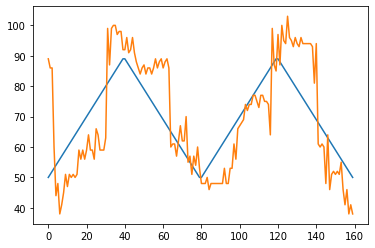

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

# plt.plot(list(np.ones(500)*24))

#plt.plot(list(np.ones(200)*50))
#plt.plot(list(np.ones(20)*50))
plt.plot(testing_data_unnorm)
plt.plot(predicted_notes_lst)

In [84]:
from collections import Counter
c = Counter(predicted_notes_lst)
c

Counter({89: 1,
         86: 2,
         60: 1,
         44: 228,
         48: 60,
         38: 5,
         41: 3,
         35: 1,
         34: 1,
         33: 1,
         52: 3,
         46: 158,
         53: 12,
         49: 3,
         45: 19,
         47: 2})